In [23]:
using Random, Plots, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures, Revise

In [24]:
Revise.track("./SSA-basic.jl")
include("./SSA-basic.jl")
using .SSAnonVD

In [5]:
df_nuc = DataFrame(CSV.File("./data/nuclear-vol-corr.csv"));

In [6]:
df_cyto = DataFrame(CSV.File("./data/cyto-vol-corr.csv"));

In [17]:
df_nuc

,Group,N,Mean,Variance,FF,gene
,Int64,Int64,Float64,Float64,Float64,String31
1,1,1142,0.560241,0.533055,0.951474,bub1WTymEGFP
2,2,1144,2.6722,2.48171,0.928712,cdc13endog
3,3,2155,0.284678,0.279769,0.982755,mad1WTymEGFP
4,4,1382,0.318194,0.295582,0.928936,mad1endog
5,5,3064,0.945392,0.798858,0.845001,mad2WTymEGFP
6,6,2661,0.345995,0.336913,0.973754,mad3WTymEGFP
7,7,1425,3.55597,2.93585,0.825612,rpb1endog
8,8,589,1.29554,1.12129,0.865498,sep1WTymEGFP-hph


In [10]:
df_cyto

,Group,N,Mean,Variance,FF,gene
,Int64,Int64,Float64,Float64,Float64,String31
1,1,1142,4.40026,2.73219,0.620915,bub1WTymEGFP
2,2,1144,18.5201,18.4671,0.99714,cdc13endog
3,3,2155,2.85252,1.87396,0.656948,mad1WTymEGFP
4,4,1382,1.74182,1.07961,0.619818,mad1endog
5,5,3064,2.89691,2.38782,0.824265,mad2WTymEGFP
6,6,2661,3.52603,2.55645,0.725023,mad3WTymEGFP
7,7,1425,17.8811,11.5739,0.64727,rpb1endog
8,8,589,5.42553,4.77273,0.879679,sep1WTymEGFP-hph


In [187]:
mad1_N = df_nuc[!,"N"][4];
# mad1_nuc_mean = df_cyto[!,"Mean"][4];
mad1_cyto_mean = df_cyto[!,"Mean"][4];
mad1_nuc_FF = df_nuc[!,"FF"][4];
mad1_cyto_FF = df_cyto[!,"FF"][4];

In [188]:
mad1_N

1382

Also specify the hyperparameters before.

In [189]:
hypars = [3,3];

In [190]:
tdeg = 1;
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [191]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

sim_time (generic function with 1 method)

In [192]:
function simulator_fn(pars)
    op = SSA(mad1_N, pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn (generic function with 1 method)

In [193]:
function new_distance(traj1::Matrix, traj2::Matrix)
    return sum([((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end

new_distance (generic function with 2 methods)

In [194]:
simulator_fn([1,1,1])

3×1 Matrix{Float64}:
 1.3487698986975398
 0.796419881141097
 0.6630046647792076

In [197]:
new_distance(simulator_fn([1,1,1]),simulator_fn([1,1,1]))

0.001019274182465598

In [198]:
thres_cutoff = sum([new_distance(simulator_fn([1,10,1]),simulator_fn([1,10,1])) for i in 1:1000])/1000

0.006092966920655092

In [79]:
using GpABC

## Standard rejection based sampler

In [199]:
# ABC priors
priors = [Uniform(((hypars[1]-1)/2)*0.5,((hypars[1]-1)/2)*10.5), Uniform(0.5, 10.5), Uniform(0.5,100.5)]

# ABC hpars
n_particles = 1000;
threshold = 0.1;

[ Info: GpABC rejection simulation. ϵ = 0.1.
[ Info: GpABC rejection simulation. Accepted 168/1000 particles.
[ Info: GpABC rejection simulation. Accepted 363/2000 particles.
[ Info: GpABC rejection simulation. Accepted 537/3000 particles.
[ Info: GpABC rejection simulation. Accepted 716/4000 particles.
[ Info: GpABC rejection simulation. Accepted 883/5000 particles.


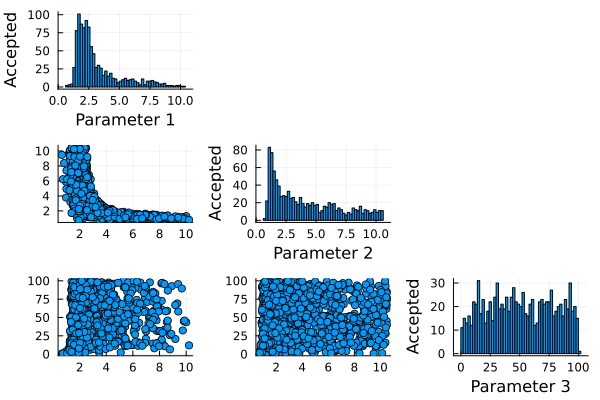

In [200]:
sim_result = SimulatedABCRejection(reshape([mad1_cyto_mean,mad1_nuc_FF,mad1_cyto_FF],(3,1)), 
    simulator_fn, priors, threshold, n_particles;
    max_iter=convert(Int, 1e4),
    distance_function = new_distance,
    write_progress=true)
plot(sim_result)

## ABC-SMC sampler

We now use a threshold of schedules to hone in on the regions of high posterior probability.

In [201]:
threshold_schedule = [0.2, 0.1, 0.05, 0.025, 0.01];

In [ ]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]
sim_abcsmc_res = SimulatedABCSMC(reshape([mad1_cyto_mean,mad1_nuc_FF,mad1_cyto_FF],(3,1)),
    simulator_fn,
    priors,
    threshold_schedule,
    n_particles; 
    write_progress=true)
plot(sim_abcsmc_res, population_colors=population_colors)